In [13]:
from seinfeld_playground import *
from train_utils import split_train_test
from compare_models import plot_confusion_matrix, compare_models_roc_curve
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = load_corpus()

df = getSceneData(df)
print("There are %d sentances, %d funny, %d not funny" % (len(df), sum(df.is_funny), len(df) - sum(df.is_funny)))
df.head(2)

There are 46497 sentances, 13560 funny, 32937 not funny


,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,num_words,season,...,total_lines,txt,global_episode_num,time_from_prev,new_scene,scene_text,scene_characters,n_scene_characters,scene_number_in_episode,global_scene_number
0,JERRY,3.050,The Watch,6,True,3.6,1.944,0,9,4,...,486,"Here's what happened last week, incase you mi...",1,0.000,True,"Here's what happened last week, incase you mi...","{MORTY, JERRY}",2,1,1
1,JERRY,6.371,The Watch,6,False,NaN,3.297,1,16,4,...,486,"George and I went up to NBC, and we told them...",1,0.024,False,"Here's what happened last week, incase you mi...","{MORTY, JERRY}",2,1,1


In [3]:
len(df.global_episode_num.unique())

96

In [7]:
df_train, df_test = split_train_test(df, 0.2)
df_train.shape, df_test.shape

((37738, 22), (8759, 22))

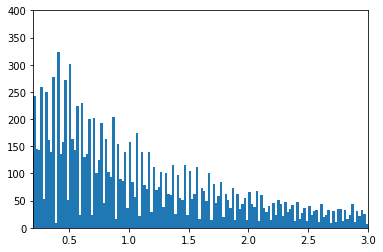

In [8]:
plt.hist(df['time_from_prev'], bins=([i / 100 for i in range(0,302,2)]) + ([10,30,50,100]))
plt.xlim(0.2,3)
plt.ylim(0,400)
plt.show()

Try to decide on thershold, it's pretty hard.  
I preffer not to have FP so Will pick 1.8

In [9]:
df_kramer_start = df[(df.character == 'KRAMER') & (df.new_scene)] 
print('kramer first in secnce funny: ', sum(df_kramer_start.is_funny) / len(df_kramer_start))
print('total funny:', sum(df.is_funny) / len(df))

kramer first in secnce funny:  0.36054421768707484
total funny: 0.29163171817536615


# One Hot Encoding

In [10]:
cv, X_train = getOneHotEncoding(df_train.txt)
X_test = cv.transform(df_test.txt)
y_test = df_test.is_funny
y_train = df_train.is_funny

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
y_hat_lr = lr.predict_proba(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [21]:
1588 / (3136 + 1588)

0.336155800169348

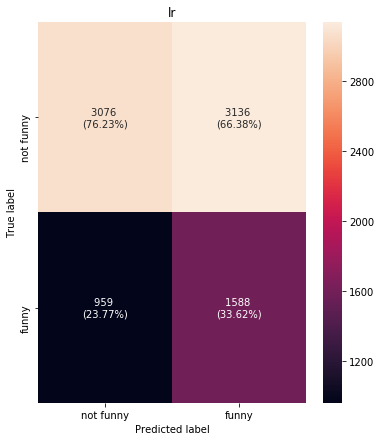

In [20]:
plot_confusion_matrix(y_test, [y_hat_lr[:,1]], ['lr'])

## SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(probability=1, gamma='auto')
svm.fit(X_train, y_train)
y_hat_svm = svm.predict_proba(X_test)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_hat_lr[:,1] > 0.22)

In [ ]:
funny_words = np.squeeze(np.asarray((freq[np.array(df.is_funny).astype(np.bool)].sum(axis=0)) / (np.squeeze(np.asarray(freq.sum(axis=0)).astype(np.float)))))

# Compare Models

In [ ]:
from compare_models import compare_models_roc_curve
auc = compare_models_roc_curve(y_test, [y_hat_lr[:,1], y_hat_svm[:,1]], ['lr', 'svm'])
print(auc)

In [ ]:
plot_confusion_matrix(y_test, [y_hat_lr[:,1], y_hat_svm[:,1]], ['lr', 'svm'])

# Scene

In [ ]:
# merge scene text
text_for_scene = []
charcteres_scence = []
number_rows_scence = []
for i, row in df.iterrows():
    if row['new_scene']:
        text_for_scene.append(row['txt'])
        charcteres_scence.append(set([row.character]))
        number_rows_scence.append(1)
    else:
        text_for_scene[-1] += "\n" + row['txt']
        charcteres_scence[-1].add(row.character)
        number_rows_scence[-1] += 1
        
print(text_for_scene[107])
print(charcteres_scence[107])
print(number_rows_scence[107])
assert(len(number_rows_scence) == len(charcteres_scence) and len(charcteres_scence) == len(text_for_scene))

In [ ]:
df[df.n_scene_characters == 1]

In [ ]:
for i in sorted(df.n_scene_characters.unique()):
    print('scene with %d charcters funny precentage: ' % i, sum(df[(df.n_scene_characters == i)].is_funny) / len(df[(df.n_scene_characters == i)]), 'amount: ', len(df[(df.n_scene_characters == i)]))
print('total funny:', sum(df.is_funny) / len(df))

In [ ]:
# Add to the df
df['scence_text'] = [text_for_scene[i] for i in range(len(number_rows_scence)) for _ in range(number_rows_scence[i])]
df['scence_charcteres'] = [charcteres_scence[i] for i in range(len(number_rows_scence)) for _ in range(number_rows_scence[i])]
df['n_scence_charcteres'] = df.scence_charcteres.str.len()

In [ ]:
from seinfeld_laugh_corpus import corpus
seinfeld = corpus.load(fold_laughs=True)

In [ ]:
a = seinfeld.screenplays[0]

# Plots

In [ ]:
plt.hist(df[df.is_funny].n_scence_charcteres, bins=100, alpha=0.5, color='b', label='funny')
plt.hist(df[~df.is_funny].n_scence_charcteres, bins=100, alpha=0.5, color='g', label='not funny')
plt.legend()
plt.show()

In [ ]:
plt.hist(df[df.is_funny].length, bins=100, alpha=0.5, color='b', label='funny')
plt.hist(df[~df.is_funny].length, bins=100, alpha=0.5, color='g', label='not funny')
plt.legend()
plt.show()

In [ ]:
plt.hist(df[df.is_funny].start, bins=100, alpha=0.5, color='b', label='funny', density=1)
plt.hist(df[~df.is_funny].start, bins=100, alpha=0.5, color='g', label='not funny', density=1)
plt.legend()
plt.show()

In [ ]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "start", bins=50, color='b')
plt.show()

In [ ]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "length", bins=50, color='b')
plt.show()

In [ ]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "season", bins=50, color='b')
plt.show()

In [ ]:
g = sns.FacetGrid(df[df['character'].isin(["JERRY", "ELAINE", "KRAMER", "GEORGE"])], col='character', row='is_funny')
g.map(sns.distplot, "start", bins=50, color='b')
plt.show()

In [ ]:
g2 = sns.FacetGrid(df, col='character', row='is_funny')
g2.map(sns.distplot, "num_words", bins=50, color='b')
plt.show()